In [2]:
#https://www.kaggle.com/boltzmannbrain/nab#Twitter_volume_IBM.csv
#https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770
#https://github.com/infusedIdeas/ai_software_dev/blob/master/AI/Anomaly%20Detection%20and%20AutoEncoders/Bearing%20Failure%20Anomaly%20Detection%20-%20Dense.ipynb
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

from random import seed
from random import randrange

/Users/jeremyney/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jeremyney/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jeremyney/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jeremyney/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [3]:
merged_data = pd.read_csv('Twitter_volume_FB.csv', index_col = 0)
merged_data.index = pd.to_datetime(merged_data.index)
merged_data.fillna(merged_data.mean(), inplace=True)
merged_data = pd.DataFrame(merged_data)
merged_data.head()

,fb,goog,amzn
2015-02-26 21:42:00,53.0,35,57.0
2015-02-26 21:47:00,64.0,41,43.0
2015-02-26 21:52:00,49.0,32,55.0
2015-02-26 21:57:00,48.0,36,64.0
2015-02-26 22:02:00,22.0,32,93.0


In [4]:
msk = np.random.rand(len(merged_data)) < 0.8

In [6]:
dataset_train = merged_data[msk]
dataset_test = merged_data[~msk]
print("Training dataset shape:", dataset_train.shape)
print("Test dataset shape:", dataset_test.shape)

Training dataset shape: (12760, 3)
Test dataset shape: (3082, 3)


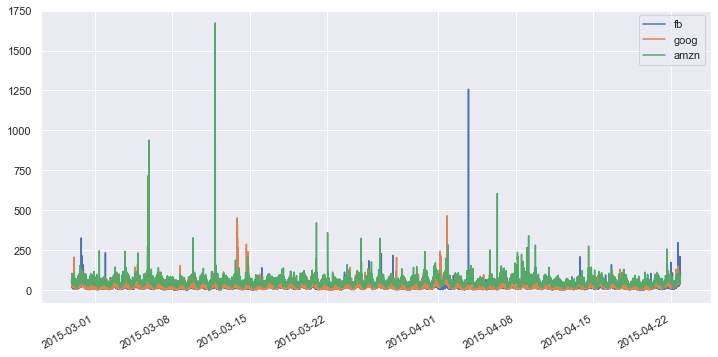

In [7]:
dataset_train.plot(figsize = (12,6))

In [8]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

In [17]:
seed(10)
set_random_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [18]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Train on 12122 samples, validate on 638 samples
Epoch 1/100
12122/12122 [==============================] - 1s 118us/step - loss: 1.7647e-04 - val_loss: 1.3254e-04
Epoch 2/100
12122/12122 [==============================] - 1s 106us/step - loss: 9.3606e-05 - val_loss: 1.3346e-04
Epoch 3/100
12122/12122 [==============================] - 1s 101us/step - loss: 8.8620e-05 - val_loss: 1.2055e-04
Epoch 4/100
12122/12122 [==============================] - 1s 102us/step - loss: 8.4514e-05 - val_loss: 1.2862e-04
Epoch 5/100
12122/12122 [==============================] - 1s 102us/step - loss: 8.2776e-05 - val_loss: 1.1873e-04
Epoch 6/100
12122/12122 [==============================] - 1s 112us/step - loss: 8.0963e-05 - val_loss: 1.2086e-04
Epoch 7/100
12122/12122 [==============================] - 1s 104us/step - loss: 8.0272e-05 - val_loss: 1.2371e-04
Epoch 8/100
12122/12122 [==============================] - 1s 99us/step - loss: 8.0115e-05 - val_loss: 1.2000e-04
Epoch 9/100
12122/12122 [========

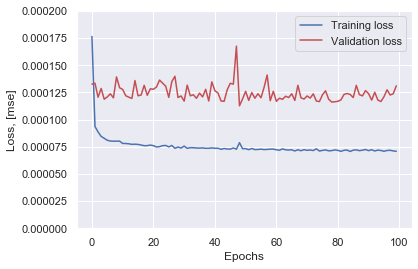

In [22]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.0002])
plt.show()

(0.0, 0.04)

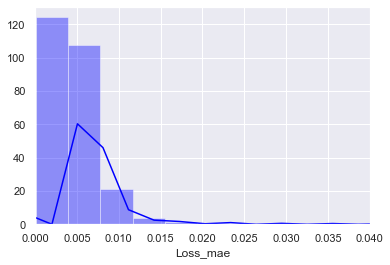

In [21]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 100, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.04])

In [23]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.02
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2015-02-26 21:52:00,0.004491,0.02,False
2015-02-26 22:17:00,0.001331,0.02,False
2015-02-26 22:32:00,0.003010,0.02,False
2015-02-26 22:37:00,0.000452,0.02,False
2015-02-26 22:52:00,0.003078,0.02,False


In [24]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.02
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

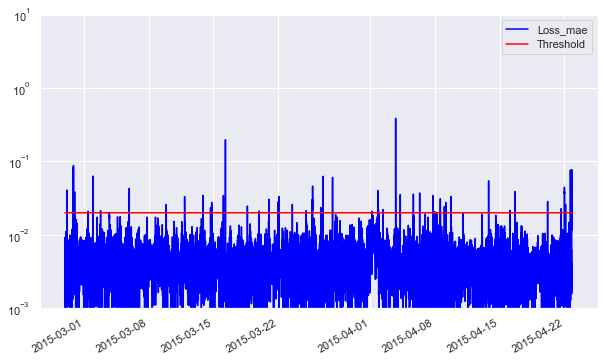

In [25]:
scored.plot(logy=True, figsize = (10,6), ylim = [1e-3,1e1], color = ['blue','red'])

In [123]:
scored.to_csv('/Users/Jeremyney/downloads/scored.csv')